In [17]:
import yfinance as yf
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts

from itertools import combinations
import matplotlib.pyplot as plt

# A. Explore relationship betwen forex pair movements etc yada yada

This serves as a testbench for pure ccy1ccy2 trades 

In [18]:
start_date = "2015-01-01"
end_date = "2022-12-31"

In [19]:
# get close data
usd_sgd_data = yf.Ticker("USDSGD=X").history(start=start_date, end=end_date)["Close"]
usd_cad_data = yf.Ticker("USDCAD=X").history(start=start_date, end=end_date)["Close"]

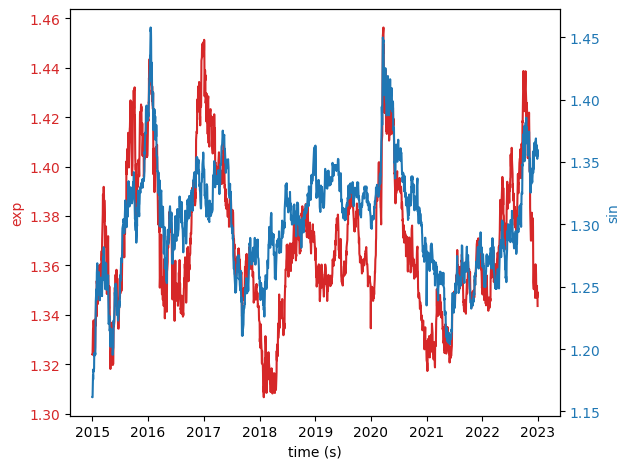

In [20]:
fig, ax1 = plt.subplots()

color = "tab:red"
ax1.set_xlabel("time (s)")
ax1.set_ylabel("exp", color=color)
ax1.plot(usd_sgd_data, color=color)
ax1.tick_params(axis="y", labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis

color = "tab:blue"
ax2.set_ylabel("sin", color=color)  # we already handled the x-label with ax1
ax2.plot(usd_cad_data, color=color)
ax2.tick_params(axis="y", labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

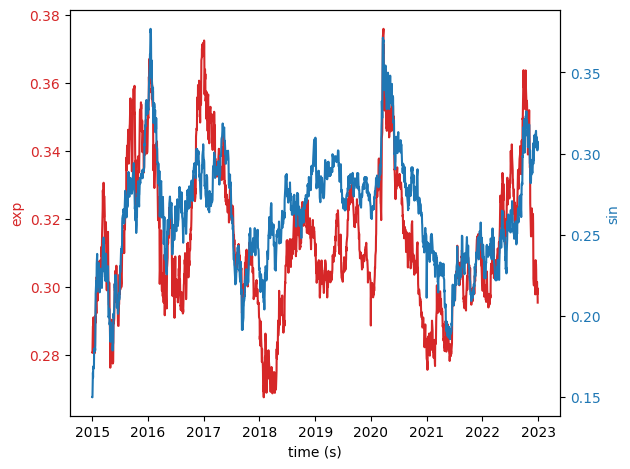

In [21]:
fig, ax1 = plt.subplots()

color = "tab:red"
ax1.set_xlabel("time (s)")
ax1.set_ylabel("exp", color=color)
ax1.plot(np.log(usd_sgd_data), color=color)
ax1.tick_params(axis="y", labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis

color = "tab:blue"
ax2.set_ylabel("sin", color=color)  # we already handled the x-label with ax1
ax2.plot(np.log(usd_cad_data), color=color)
ax2.tick_params(axis="y", labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [22]:
df_together = pd.DataFrame(
    zip(usd_sgd_data, usd_cad_data),
    index=usd_cad_data.index,
    columns=["usdsgd", "usdcad"],
)


df_together

,usdsgd,usdcad
Date,,
2015-01-01 00:00:00+00:00,1.32390,1.16146
2015-01-02 00:00:00+00:00,1.32378,1.16140
2015-01-05 00:00:00+00:00,1.33425,1.17930
2015-01-06 00:00:00+00:00,1.33430,1.17570
2015-01-07 00:00:00+00:00,1.33402,1.18370
...,...,...
2022-12-26 00:00:00+00:00,1.35170,1.35897
2022-12-27 00:00:00+00:00,1.34680,1.35570
2022-12-28 00:00:00+00:00,1.34760,1.35250


In [23]:
return_df = (df_together / df_together.shift(1)) - 1
return_df

,usdsgd,usdcad
Date,,
2015-01-01 00:00:00+00:00,NaN,NaN
2015-01-02 00:00:00+00:00,-0.000091,-0.000052
2015-01-05 00:00:00+00:00,0.007909,0.015412
2015-01-06 00:00:00+00:00,0.000038,-0.003053
2015-01-07 00:00:00+00:00,-0.000210,0.006804
...,...,...
2022-12-26 00:00:00+00:00,0.000222,-0.003454
2022-12-27 00:00:00+00:00,-0.003625,-0.002406
2022-12-28 00:00:00+00:00,0.000594,-0.002360


## Test for Cointegration
Using the ts.coint function, we are using the Engle-Gragner test
https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.coint.html

I think the way to read the result is you compare tour test statistic with the crit values. 

If your test statistic is smaller than the crit value for that significance level, then your series (plural) are cointegrated up to that significance level

e.g. test statistic = -3.5, crit value for 5% significance = -3.3
your series(plural) are coint with 5% significance level

In [24]:
# lets do it
coint_result = ts.coint(df_together["usdsgd"], df_together["usdcad"])
print(f"test statistic = {coint_result[0]}")
print(
    f"crit values (from left to right 1%, 5%, 10% significance level)= {coint_result[2]}"
)

test statistic = -3.3334016170014387
crit values (from left to right 1%, 5%, 10% significance level)= [-3.90170548 -3.33906489 -3.04648673]


In [25]:
df_together_log = np.log(df_together)
df_together_log

,usdsgd,usdcad
Date,,
2015-01-01 00:00:00+00:00,0.280582,0.149678
2015-01-02 00:00:00+00:00,0.280491,0.149626
2015-01-05 00:00:00+00:00,0.288369,0.164921
2015-01-06 00:00:00+00:00,0.288407,0.161864
2015-01-07 00:00:00+00:00,0.288197,0.168645
...,...,...
2022-12-26 00:00:00+00:00,0.301363,0.306727
2022-12-27 00:00:00+00:00,0.297731,0.304318
2022-12-28 00:00:00+00:00,0.298325,0.301955


## Prof Ben's Cointegration

In [26]:
y = df_together["usdsgd"]  # usdsgd
x = df_together["usdcad"]  # dxy
result = sm.OLS(y.to_numpy(), sm.tools.add_constant(x.to_numpy())).fit()
result.params
mu = result.params[0]
gamma = result.params[1]

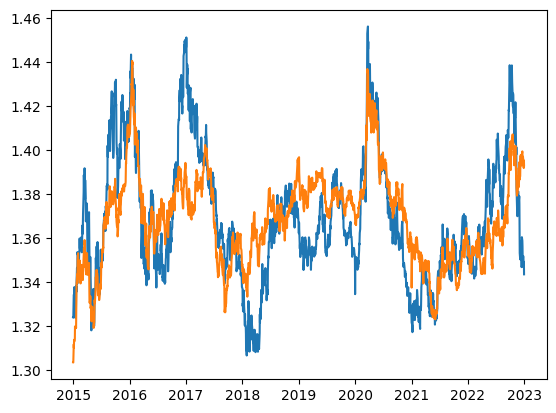

In [27]:
# print model vs actual
model = gamma * x + mu
plt.plot(y)
plt.plot(model)

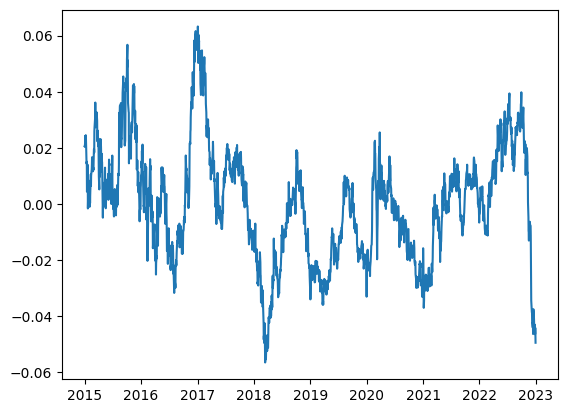

In [28]:
# spread, idk why prof ben coded it like this
df_together["spread"] = (y - gamma * x) - mu
plt.plot(df_together["spread"])

### Note regarding stationarity test

if your test statistic is smaller than critical value for a corresponding significance level, means your series is stationary up to that significance level

e.g. test_statistic = -3.5, 1% significance critval = - 3.3 
your series is stationary with significane level of 99%

another thing to check is p value
p value > 0.05 ; accept null & your series is NOT stationary
p value < 0.05 ; reject null hypothesis & your series IS STATIONARY

In [29]:
result_adf = ts.adfuller(df_together["spread"])
print(f"test statistic {result_adf[0]}")
print(f"p value {result_adf[1]}")
print(f"critical values for test statistic {result_adf[4]}")

test statistic -3.3320649458673866
p value 0.013504613670520789
critical values for test statistic {'1%': -3.4334947554105537, '5%': -2.862929213668854, '10%': -2.567509552921939}


## ok now we actually do the portfolio

In [30]:
return_df

,usdsgd,usdcad
Date,,
2015-01-01 00:00:00+00:00,NaN,NaN
2015-01-02 00:00:00+00:00,-0.000091,-0.000052
2015-01-05 00:00:00+00:00,0.007909,0.015412
2015-01-06 00:00:00+00:00,0.000038,-0.003053
2015-01-07 00:00:00+00:00,-0.000210,0.006804
...,...,...
2022-12-26 00:00:00+00:00,0.000222,-0.003454
2022-12-27 00:00:00+00:00,-0.003625,-0.002406
2022-12-28 00:00:00+00:00,0.000594,-0.002360


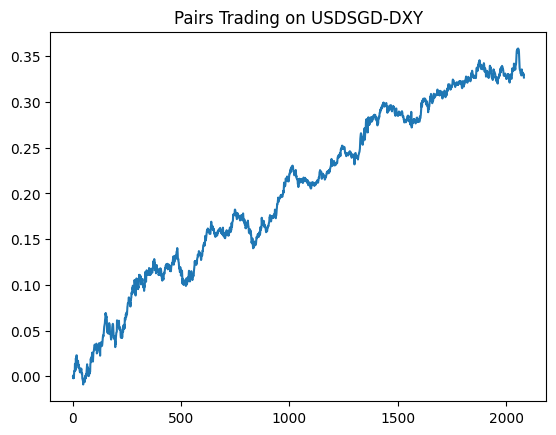

In [31]:
df_together["spread_position"] = 0
df_together.loc[df_together["spread"] > 0, "spread_position"] = -1
df_together.loc[df_together["spread"] < 0, "spread_position"] = 1
df_together["spread_position"] = df_together["spread_position"].shift(1)
df_together["sgd_position"] = df_together["spread_position"]
df_together["dxy_position"] = df_together["spread_position"] * gamma * -1

df_together["dailypnl"] = df_together["sgd_position"] * return_df["usdsgd"].shift(
    -1
) + df_together["dxy_position"] * return_df["usdcad"].shift(-1)


df_together["cumpnl"] = df_together["dailypnl"].cumsum()
plt.plot(df_together["cumpnl"].values, label="Pairs Trading on USDSGD-DXY")
plt.title("Pairs Trading on USDSGD-DXY")
plt.show()

In [32]:
df_together

,usdsgd,usdcad,spread,spread_position,sgd_position,dxy_position,dailypnl,cumpnl
Date,,,,,,,,
2015-01-01 00:00:00+00:00,1.32390,1.16146,0.020464,NaN,NaN,NaN,NaN,NaN
2015-01-02 00:00:00+00:00,1.32378,1.16140,0.020372,-1.0,-1.0,0.463008,-0.000773,-0.000773
2015-01-05 00:00:00+00:00,1.33425,1.17930,0.022554,-1.0,-1.0,0.463008,-0.001451,-0.002224
2015-01-06 00:00:00+00:00,1.33430,1.17570,0.024271,-1.0,-1.0,0.463008,0.003360,0.001136
2015-01-07 00:00:00+00:00,1.33402,1.18370,0.020287,-1.0,-1.0,0.463008,-0.003152,-0.002016
...,...,...,...,...,...,...,...,...
2022-12-26 00:00:00+00:00,1.35170,1.35897,-0.043185,1.0,1.0,-0.463008,-0.002511,0.328914
2022-12-27 00:00:00+00:00,1.34680,1.35570,-0.046571,1.0,1.0,-0.463008,0.001687,0.330601
2022-12-28 00:00:00+00:00,1.34760,1.35250,-0.044289,1.0,1.0,-0.463008,-0.001330,0.329271
